In [1]:
###### cell 0
#cell for imports and system variable set ups
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from tensorflow.keras import backend
from tensorflow.python.framework import ops
#import random
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import cmath
from sklearn import metrics

print("Done")

Done


In [2]:
###### cell 1:
#data loader
#note: scipy fft requires the array to be in M x N format, where M = samples, and N = features

def load_data(file_var_names):
    print("Loading data...", end='')
    load_x = np.load(file_var_names[0])
    load_y = np.load(file_var_names[1])

    #print(Y_complex[0])
    train_x = load_x[file_var_names[2]].T
    train_y = load_y[file_var_names[3]]

    y_value = 1

    #ones = [i for i, x in enumerate(train_y) if x == 1]
    #zeros = [i for i, x in enumerate(train_y) if x == 0]
    #print(ones)
    #print(train_x.shape)
    #plt.plot(X[0])
    #plt.show()

    print(train_x.shape)
    print("train_y shape: ", train_y.shape)
    num_batch = 1
    samples_per_batch = train_x.shape[2]//num_batch
    train_x_fft = np.zeros((num_batch, train_x.shape[1], samples_per_batch)).astype('complex64')
    train_y_batched = np.zeros((num_batch, samples_per_batch,train_y.shape[1]))
    print(train_x_fft.shape)
    print("y batched: ", train_y_batched.shape)
    cur_batch = 0
    cur_sample = 0
    for col in range(train_x_fft.shape[2]):
        fftx = np.fft.fft(train_x[0,:,col])
        real_data = np.real(fftx)
        imag_data = np.imag(fftx)
        #real_data = ( real_data - real_data.mean() ) / real_data.std()
        #imag_data = ( imag_data - imag_data.mean() ) / imag_data.std()
        x_source_norm = real_data + imag_data*1j
        train_x_fft[cur_batch,:,cur_sample] = x_source_norm
        train_y_batched[cur_batch,cur_sample,:] = train_y[col,:]
        if cur_sample >= samples_per_batch:
            cur_batch += 1
            cur_sample = 0
        if cur_batch >= num_batch:
            break
        cur_sample += 1

    train_x = tf.convert_to_tensor(train_x_fft,dtype='complex64')
    print(np.sum(train_y.flatten()))
    train_y = tf.cast(train_y_batched,dtype='float32')
    print("Done")
    return train_x, train_y
train_x, train_y = load_data(['./train_x.npz', './train_y.npz', 'train_x', 'train_y'])

print("Done")

Loading data...(1, 4096, 10000)
train_y shape:  (10000, 84)
(1, 4096, 10000)
y batched:  (1, 10000, 84)
33362.0
Done
Done


In [3]:
print(train_x)

tf.Tensor(
[[[-7.32182443e-01+0.j          6.12951592e-02+0.j
    4.18733180e-01+0.j         ... -2.01207459e-01+0.j
    1.66948724e+00+0.j          1.66138951e-02+0.j        ]
  [-8.62999678e-01-0.0891651j   2.79659554e-02+0.00613794j
    4.48797882e-01+0.03152297j ...  8.31077278e-01-0.13428916j
   -3.74569356e-01-0.9135404j   1.15788646e-01+0.00239535j]
  [-3.58897984e-01+0.05327325j -1.56238116e-03-0.06451115j
    4.25156295e-01+0.0040571j  ...  3.30463946e-01+0.08992868j
    1.19004071e+00+0.20340359j  4.74000946e-02-0.02612199j]
  ...
  [-4.59978044e-01-0.22489417j  6.57720715e-02-0.00539386j
    4.35869277e-01+0.04393807j ...  3.31263505e-02+0.37653005j
    3.07998627e-01-0.45818123j  7.53297657e-02+0.02720537j]
  [-3.58897984e-01-0.05327325j -1.56238116e-03+0.06451115j
    4.25156295e-01-0.0040571j  ...  3.30463946e-01-0.08992868j
    1.19004071e+00-0.20340359j  4.74000946e-02+0.02612199j]
  [-8.62999678e-01+0.0891651j   2.79659554e-02-0.00613794j
    4.48797882e-01-0.03152297j

In [4]:
###### cell 2:
#helper functions
complex_dtype = 'complex64'
def cReLU(x):
    #print(x)
    ret_real = tf.math.real(x)
    ret_imag = tf.math.imag(x)
    ret_real = tf.nn.relu(ret_real)
    ret_imag = tf.nn.relu(ret_imag)
    return tf.complex(ret_real,ret_imag)
np_cReLU = np.vectorize(cReLU)

def P2C(radii, angles):
    x = tf.multiply(radii, tf.math.cos(angles))
    y = tf.multiply(radii, tf.math.sin(angles))
    return tf.cast(tf.complex(x,y),dtype='complex64')

y = tf.constant([2.0, 8.0])
x = tf.constant([2.0, 8.0])

#print(P2C(y,x))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class ComplexDenseLayer(keras.layers.Layer):

    def __init__(self,input_dim,num_outputs,activation):
        super(ComplexDenseLayer, self).__init__()
        self.num_outputs = num_outputs

        real = np.random.randn(input_dim, self.num_outputs) * np.sqrt(2/self.num_outputs)
        imag = np.random.randn(input_dim, self.num_outputs) * np.sqrt(2/self.num_outputs)
        complex_mat = tf.cast(tf.complex(real,imag),complex_dtype)
        self.w = tf.Variable(complex_mat, dtype=complex_dtype,trainable=True)
        bias_real = np.random.rand(self.num_outputs,1)
        bias_imag = np.random.rand(self.num_outputs,1)
        bias_complex = tf.cast(tf.complex(bias_real, bias_imag),complex_dtype)
        self.b = tf.Variable(bias_complex,dtype=complex_dtype,trainable=True)
        self.activation=activation

    def call(self,inputs):
        batch_b = tf.repeat(self.b,inputs.shape[1],1)
        out = tf.matmul(tf.transpose(self.w),inputs)+batch_b
        if self.activation=="phase":
            out = tf.convert_to_tensor(P2C(tf.math.abs(out)*0.5,tf.math.angle(out)),dtype='complex64')
            out += tf.convert_to_tensor(P2C(tf.matmul(tf.transpose(tf.math.abs(self.w)),tf.math.abs(inputs)*0.5),tf.math.angle(out)),dtype='complex64')
            out += batch_b
        #print(type(out))
        return out

class Complex1DConvLayer(keras.layers.Layer):
    def __init__(self, input_dim, stride, padding, kernel_size):
        output_shape = (input_dim-kernel_size + 2*padding)/stride
    def call(self,inputs):
        batch_b = tf.repeat(self.b, inputs.shape[1],1)
        return tf.matmul(tf.transpose(self.w), inputs)+batch_b

class Complex1DMaxPool(keras.layers.Layer):
    def __init__(self,input_dim,stride,padding,kernel_size):
        self.stride = stride
        self.padding = padding
        self.kernel_size = kernel_size
        self.out_shape = (input_dim-kernel_size + 2*padding)/stride
    def call(self,inputs):
        #assumes data is given as features x samples
        out = tf.convert_to_tensor(np.zeros((self.out_shape, inputs.shape[1])) + np.zeros((self.out_shape, inputs.shape[1]))*1j, dtype='complex64')
        for sample in range(inputs.shape[1]):
            out[:,sample] = tf.convert_to_tensor(maxMagnitude(inputs[:,sample].numpy()), dtype='complex64')
        return out
        
    def MaxMagnitude(sample):
        #assumes that sample is given as a numpy array
        max_pooled = np.zeros((self.out_shape,1)) + np.zeros((self.out_shape,1))*1j
        sample_mag = abs(sample)
        out_index = 0
        kernel_start = 0
        while(out_index < max_pooled.shape[0]):
            max_pooled[out_index] = sample[kernel_start + np.argmax(sample_mag[kernel_start:kernel_start+self.kernel_size])]
            out_index += 1
            kernel_start += self.stride
        return max_pooled

class ComplexFCNetwork(keras.Model):
    def __init__(self, dimensions, activation, name="ComplexValueFC", **kwargs):
        super(ComplexFCNetwork, self).__init__(name=name,**kwargs)
        self.specs = str(dimensions)
        complex_dimensions = dimensions[0]
        real_dimensions = dimensions[1]
        self.orig_shape = complex_dimensions[0]
        self.layerz = []
        self.m = []
        self.v = []
        self.num_complex_layers = len(complex_dimensions) - 1
        self.num_real_layers = len(real_dimensions)
        #complex layers
        for index in range(len(complex_dimensions)-1):
            self.layerz.append(ComplexDenseLayer(complex_dimensions[index],complex_dimensions[index+1],activation))
            #weight momentum
            self.m.append(np.zeros((complex_dimensions[index],complex_dimensions[index+1]))+np.zeros((complex_dimensions[index],complex_dimensions[index+1]))*1j)
            self.v.append(np.zeros((complex_dimensions[index],complex_dimensions[index+1]))+np.zeros((complex_dimensions[index],complex_dimensions[index+1]))*1j)
            #bias momentum
            self.m.append(np.zeros((complex_dimensions[index+1],1)))
            self.v.append(np.zeros((complex_dimensions[index+1],1)))
        #complex-real transition
        act = 'sigmoid'
        if len(real_dimensions) > 1:
            act = 'relu'
            
        self.layerz.append(tf.keras.layers.Dense(real_dimensions[0],activation=act))
        self.m.append(np.zeros((complex_dimensions[-1]*2, real_dimensions[0])))
        self.v.append(np.zeros((complex_dimensions[-1]*2, real_dimensions[0])))
        #bias momentum
        self.m.append(np.zeros((real_dimensions[0])))
        self.v.append(np.zeros((real_dimensions[0])))
        if len(real_dimensions) > 1:
            real_index = 1
            while(real_index < len(real_dimensions)):
                #print("real: ", real_index)
                if (real_index +1) >= len(real_dimensions):
                    act = 'sigmoid'
                else:
                    act = 'relu'
                #print("ading layer: ", real_dimensions[real_index])
                self.layerz.append(tf.keras.layers.Dense(real_dimensions[real_index],activation=act))
                self.m.append(np.zeros((real_dimensions[real_index-1], real_dimensions[real_index])))
                self.v.append(np.zeros((real_dimensions[real_index-1],real_dimensions[real_index])))
                #bias momentum
                self.m.append(np.zeros((real_dimensions[real_index])))
                self.v.append(np.zeros((real_dimensions[real_index])))
                real_index += 1

    def call(self, inputs):
        #print("self.layerz: ", self.layerz)
        ret = inputs
        index = 0
        '''print(ret.shape)
        print("input: ", ret)
        print("")
        foi = 1'''
        while index < self.num_complex_layers:
            '''to_plot = ret[foi,:].numpy()
            X = np.real(to_plot)
            Y = np.imag(to_plot)
            plt.scatter(X,Y,color='red')
            plt.show()
            print("real: ", X)
            print("imag; ", Y)'''
            ret = cReLU((self.layerz[index])(ret))
            index += 1
        '''to_plot = ret[foi,:].numpy()
        X = np.real(to_plot)
        Y = np.imag(to_plot)
        plt.scatter(X,Y,color='red')
        plt.show()
        print("real: ", X)
        print("imag; ", Y)'''
        #ret_real = tf.math.real(ret)
        #ret_imag = tf.math.imag(ret)
        #ret = tf.transpose(tf.concat([ret_real,ret_imag],0))
        ret_r = tf.math.real(ret)
        ret_phi = tf.math.imag(ret)
        ret = tf.concat([ret_r,ret_phi],0)
        '''print("mag: ", ret_r)
        print("")
        print("phase: ", ret_phi)
        print("")
        #ret = tf.transpose(ret)
        print("transition: ", ret)'''
        ret = tf.transpose(ret)
        '''print("")
        print("tranposed: ", ret)'''
        
        while index < (self.num_complex_layers + self.num_real_layers):
            #print("passing through dense")
            ret = (self.layerz[index])(ret)
            #print("layer", index, ":", ret)
            #print("dense shapes: ", ret.shape)
            index += 1
        return ret

def cadam(lr,grad,m,v,t):
    #print("m: ", m.shape)
    #print("v: ", v.shape)
    #print("grad: ", grad.shape)
    b1 = 0.9
    b2 = 0.999
    epsilon = .0001
    m = b1 * m + (1 - b1) * (grad)
    v = b2 * v + (1 - b2) * (np.power(grad,2))
    m_hat = m/(1-np.power(b1,t+1))
    v_hat = v/(1-np.power(b2,t+1))
    return lr*m_hat/(np.sqrt(v_hat)+epsilon)
print("Done")

Done


In [5]:
#validation cell
def validate(model, val_x, val_y, mse_loss_fn):
    epochs = 1
    test_out = []
    loss = 0
    for epoch in range(epochs):
        for batch in range(val_x.shape[0]):
            x = val_x[batch,:,:]
            y = val_y[batch,:,:]
            y_hat = model(x)
            loss = mse_loss_fn(y, tf.math.real(y_hat))
    return loss

print("Done")

Done


In [6]:
def test(model, test_x, test_y):
    for batch in range(test_x.shape[0]):
        y_hat = model(test_x[batch,:,:])
    return y_hat

In [7]:
#random data cell
def rand_bin_array(K, N, M):
    arr = np.zeros(N*M)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return np.reshape(arr, (1,N,M))

def load_random_data(shape,out_shape):
    #shape is a tuple that dictates the input shape
    real = np.random.random(shape)
    imag = np.random.random(shape)
    fake_input = tf.convert_to_tensor(real + imag*1j,dtype='complex64')
    return tf.reshape(fake_input,(1,fake_input.shape[0],fake_input.shape[1])), rand_bin_array(0,shape[1],out_shape)

    

In [8]:
print(y)
print(type(np.where(y > 1)))


tf.Tensor([2. 8.], shape=(2,), dtype=float32)
<class 'tuple'>


In [39]:
#cell 3:
#main training/testing function
def main(train=True, dimensions=[], act="standard", model = None, train_filenames=['./train_x.npz', './train_y.npz', 'train_x', 'train_y'], valid_filenames=['./test_x.npz', './test_y.npz', 'test_x', 'test_y']):
    train_x, train_y = load_data(train_filenames)
    #train_x, train_y = load_random_data((dimensions[0][0],1000),dimensions[1][-1])
    #valid_filenames = None
    val_x = None
    val_y = None
    if valid_filenames != None:
        val_x, val_y = load_data(valid_filenames)
    if model == None:
        print("made new model!")
        model = ComplexFCNetwork(dimensions,activation=act)

    mse_loss_fn = tf.keras.losses.BinaryCrossentropy()
    learning_rate = 0.005
    epochs = 500
    if train == False:
        epochs = 1
    eta = 1
    loss_arr = []
    val_loss_arr = []
    truths = []
    falses = []
    test_out = 0
    last = None
    for epoch in range(epochs):
        print("beginning ", epoch, ": ", end = '')
        for batch in range(train_x.shape[0]):
            num_points = 100
            x = train_x[batch,:,:]
            y = train_y[batch,:,:]
            with tf.GradientTape() as tape:
                y_hat = model(x)
                test_out = y_hat
                '''print("")
                print("1s: ", [y_hat[0][i].numpy() for i in np.where(y[0] >= 1)[0]])
                print("2s: ", [y_hat[1][i].numpy() for i in np.where(y[0] >= 1)[0]])
                print("3s: ", [y_hat[2][i].numpy() for i in np.where(y[0] >= 1)[0]])
                print("")
                #print("0s: ", [y_hat[0][i].numpy() for i in np.where(y[0] <= 0)[0]])
                print("y1: ", np.where(y[0] >= 1)[0])
                print("y2: ", np.where(y[1] >= 1)[0])
                print("y3: ", np.where(y[2] >= 1)[0])
                print("")'''
                loss = mse_loss_fn(y, tf.math.real(y_hat))
                if epoch+1 == epochs: #saves the final output of our network
                    test_out = y_hat
            #print("Tape:", tape)
            if train == True:
                grads = tape.gradient(loss, model.trainable_weights)
                #print("grads: ", grads)
                #print("weights: ", model.trainable_weights[0])
                for i in range(len(model.trainable_weights)):
                    #print("I: ", i)
                    #cadam_grad = cadam(learning_rate,grads[i],model.m[i], model.v[i], epoch+1)
                    #tf.compat.v1.assign(model.trainable_weights[i],tf.math.subtract(model.trainable_weights[i]*eta,cadam_grad))
                    tf.compat.v1.assign(model.trainable_weights[i],tf.math.subtract(model.trainable_weights[i]*eta,learning_rate*grads[i]))
            print("x", end='')
        print("")
        if train == True and ((epoch) %20 == 0 or epoch == epochs):
            print("loss: ", loss.numpy())
            val_loss = None
            loss_arr.append(loss.numpy())
            if valid_filenames != None:
                print("validating...", end='')
                val_loss = validate(model,val_x, val_y, mse_loss_fn)
                print('x')
                print("Validation loss: ", val_loss)
                val_loss_arr.append(val_loss)
            #print("saving model...", end='')
            #model.save_weights('./weights/depthTest.ckpt')
            #print("Done",end='\n')
    
    print("Done")
    return test_out, train_y, loss_arr, val_loss_arr, model

#np.savez("./models/singlepointloss.npz", loss_arr=loss_arr)
print("Done")

Done


In [40]:
#cell 6
#analysis cell

def convert_to_binary(y_hat,thresh, y_value = 1):
    return np.where(y_hat > thresh, y_value, 0)

def metrics2(y_hat, truth, y_value = 1):
    #print("y_hat", y_hat)
    #print("truth", truth)
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for feature in range(len(y_hat)):
        for sample in range(len(y_hat[feature])):
            if y_hat[feature][sample] == 0 and truth[feature][sample] == 0:
                tn += 1
            elif y_hat[feature][sample] == 0 and truth[feature][sample] == y_value:
                fn += 1
            elif y_hat[feature][sample] == y_value and truth[feature][sample] == 0:
                fp += 1
            else:
                tp += 1
    return tp, fp, fn, tn
def analysis(train_test, train_y, y_value = 1):
    list_to_numpy = [train_test[0].numpy()]
    i = 1
    while ( i < len(train_test)):
        list_to_numpy.append(train_test[i].numpy())
        i += 1

    numpy_to_tensor = (np.reshape(np.asarray(list_to_numpy),(1,len(list_to_numpy),list_to_numpy[0].shape[0])))

    train_test_2 = tf.convert_to_tensor(numpy_to_tensor)

    print(train_test_2.shape)
    #train_test_2 = tf.convert_to_tensor(np.concatenate((train_test[0].numpy(),train_test[1].numpy()),axis=1))
    #print(train_test_2.shape)
    recall_arr = []
    precision_arr = []
    print(train_y.shape)
    batch = 0
    AP = 0
    best_prec = 0
    best_recall = 0
    best_half = 0
    while batch < train_y.shape[0]:
        cur_thresh = 0
        while(cur_thresh < 1):
            #print(cur_thresh)
            bin_y_hat = convert_to_binary(train_test_2,cur_thresh).astype(np.float32)
            #print(bin_y_hat.shape)
            compare = train_y.numpy()
            #print(compare.shape)
            #print(bin_y_hat[batch].shape)
            tp, fp, fn, tn = metrics(bin_y_hat[batch],compare[batch])

            print("tp: ", tp, "fp: ", fp, "fn: ", fn, "tn: ", tn)
            
            accuracy = (tp + tn) / (len(bin_y_hat)*len(bin_y_hat[0]))
            if (tp + fp) == 0:
                cur_thresh += 0.02
                break
            if (tp + fn) == 0:
                cur_thresh += 0.02
                continue
            precision = (tp) / (tp + fp)
            recall = (tp) / (tp + fn)
            half = precision * 0.75 + recall*0.25
            if half > best_half:
                best_half = half
                best_prec = precision
                best_recall = recall
            print("recall: ", recall, " precision: ", precision)
            if cur_thresh != 0:
                AP += -1*(recall-recall_arr[-1])*precision
            recall_arr.append(recall)
            precision_arr.append(precision)
            cur_thresh += 0.02
        batch += 1

    #print("Accuracy: ", accuracy, "|| Precision: ", precision, "|| Recall: ", recall)
    #print(precision_arr, recall_arr)
    print("Best Precision: ", best_prec)
    print("Best recall: ", best_recall)
    return recall_arr, precision_arr
    

Loading data...(1, 4096, 10000)
train_y shape:  (10000, 84)
(1, 4096, 10000)
y batched:  (1, 10000, 84)
33362.0
Done
Loading data...(1, 4096, 2000)
train_y shape:  (2000, 84)
(1, 4096, 2000)
y batched:  (1, 2000, 84)
6780.0
Done
made new model!
beginning  0 : x
loss:  5.0689526
validating...x
Validation loss:  tf.Tensor(4.5907426, shape=(), dtype=float32)
beginning  1 : x
beginning  2 : x
beginning  3 : x
beginning  4 : x
beginning  5 : x
beginning  6 : x
beginning  7 : x
beginning  8 : x
beginning  9 : x
beginning  10 : x
beginning  11 : x
beginning  12 : x
beginning  13 : x
beginning  14 : x
beginning  15 : x
beginning  16 : x
beginning  17 : x
beginning  18 : x
beginning  19 : x
beginning  20 : x
loss:  1.1987185
validating...x
Validation loss:  tf.Tensor(1.1607808, shape=(), dtype=float32)
beginning  21 : x
beginning  22 : x
beginning  23 : x
beginning  24 : x
beginning  25 : x
beginning  26 : x
beginning  27 : x
beginning  28 : x
beginning  29 : x
beginning  30 : x
beginning  31 :

beginning  338 : x
beginning  339 : x
beginning  340 : x
loss:  0.5275339
validating...x
Validation loss:  tf.Tensor(0.55103505, shape=(), dtype=float32)
beginning  341 : x
beginning  342 : x
beginning  343 : x
beginning  344 : x
beginning  345 : x
beginning  346 : x
beginning  347 : x
beginning  348 : x
beginning  349 : x
beginning  350 : x
beginning  351 : x
beginning  352 : x
beginning  353 : x
beginning  354 : x
beginning  355 : x
beginning  356 : x
beginning  357 : x
beginning  358 : x
beginning  359 : x
beginning  360 : x
loss:  0.5255922
validating...x
Validation loss:  tf.Tensor(0.5498747, shape=(), dtype=float32)
beginning  361 : x
beginning  362 : x
beginning  363 : x
beginning  364 : x
beginning  365 : x
beginning  366 : x
beginning  367 : x
beginning  368 : x
beginning  369 : x
beginning  370 : x
beginning  371 : x
beginning  372 : x
beginning  373 : x
beginning  374 : x
beginning  375 : x
beginning  376 : x
beginning  377 : x
beginning  378 : x
beginning  379 : x
beginning

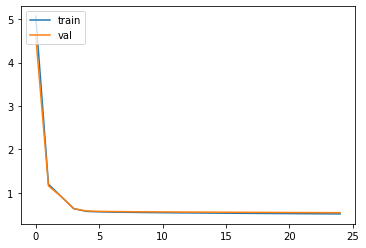

'\nout, y, loss, val_loss, out_model = main(train=Fase,dimensions=dimensionss,act="standard")\n#out, y, loss, out_model = main(train=False, model= out_model, filenames = [\'./train_x.npz\', \'./train_y.npz\', \'train_x\', \'train_y\'])\n\nfilename = out_model.specs\nrecall_arr, precision_arr = analysis(out, y)\nsave_res = np.savez("./Results/"+filename+".npz", recall_arr = recall_arr, precision_arr = precision_arr)\nplt.plot(recall_arr, precision_arr)\nplt.xlabel(\'recall\')\nplt.ylabel(\'precision\')\nplt.show()\n'

In [44]:
#cell 4
#training cell
#default = [[4096,2048,1024,512,200],[400,200,84]]
#fig,ax = plt.subplots(1,1)
dimensionss = [[4096,1024,512,200],[200,84]]
train_test, train_y, loss_arr, val_loss_arr, out_model = main(train=True,dimensions=dimensionss,act="standard",valid_filenames=['./test_x.npz', './test_y.npz', 'test_x', 'test_y'])
#cell 5
#testing model demo
#out_model = ComplexFCNetwork([[4096,2048,200],[84]])
#out_model.load_weights('./weights/EigthData.ckpt')

plt.plot(loss_arr, label='train')
plt.plot(val_loss_arr, label='val')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

'''
out, y, loss, val_loss, out_model = main(train=Fase,dimensions=dimensionss,act="standard")
#out, y, loss, out_model = main(train=False, model= out_model, filenames = ['./train_x.npz', './train_y.npz', 'train_x', 'train_y'])

filename = out_model.specs
recall_arr, precision_arr = analysis(out, y)
save_res = np.savez("./Results/"+filename+".npz", recall_arr = recall_arr, precision_arr = precision_arr)
plt.plot(recall_arr, precision_arr)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()
'''


In [46]:
def analysis2(y_hat, y):
    precision, recall, thresholds = metrics.precision_recall_curve(y, y_hat)
    return precision,recall,thresholds
    
def AP(y_hat, y):
    ap = metrics.average_precision_score(y, y_hat)
    return ap

Loading data...(1, 4096, 2000)
train_y shape:  (2000, 84)
(1, 4096, 2000)
y batched:  (1, 2000, 84)
6780.0
Done
y_hat:  [4.1613894e-13 1.3108438e-07 4.9710857e-06 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
test y:  [0. 0. 0. ... 0. 0. 0.]


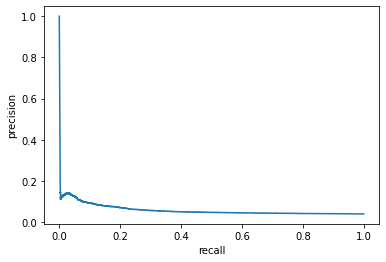

Average Precision:  0.058265440856015566


In [72]:
#out, y, loss, val_loss, out_model = main(model=out_model, train=False,dimensions=dimensionss,act="standard",train_filenames=['./test_x.npz', './test_y.npz', 'test_x', 'test_y'])
#out, y, loss, out_model = main(train=False, model= out_model, filenames = ['./train_x.npz', './train_y.npz', 'train_x', 'train_y'])
test_filenames=['./test_x.npz', './test_y.npz', 'test_x', 'test_y']
#test_filenames=['./train_x.npz', './train_y.npz', 'train_x', 'train_y']
test_x, test_y = load_data(test_filenames)
y_hat = test(out_model, test_x, test_y).numpy().flatten()
test_y = test_y[0].numpy().flatten()
print("y_hat: ", y_hat)
print("test y: ", test_y)
precision_arr, recall_arr, thresholds = analysis2(y_hat, test_y)
ap = AP(y_hat, test_y)
plt.plot(recall_arr, precision_arr)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()
print("Average Precision: ", ap)

In [73]:
ones = np.where(test_y.numpy().flatten() >= 1)[0]
ones_histo = []
for one in ones:
    ones_histo.append(y_hat[one])
    print(one)
#print(histo)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
###### 

In [ ]:
print(out)

In [ ]:
#load trained model
test_net = ComplexFCNetwork([4096,2048,200,84])
test_net.load_weights('./weights/EigthData.ckpt')
print("Done")

In [ ]:
#Load testing data
load_x = np.load('./test_x.npz')
load_y = np.load('./test_y.npz')
#load_x = np.load('./train_x.npz')
#load_y = np.load('./train_y.npz')

#print(Y_complex[0])
test_x = load_x['test_x'].T
test_y = load_y['test_y']
#test_x = load_x['train_x'].T
#test_y = load_y['train_y']
print("tesst_x", test_x.shape)
#test_x = test_x[:,:,0:100]
#test_y = test_y[0:100]

y_value = 1
print(train_y[0].shape, test_y.shape)
test_x = np.concatenate((train_x, test_x), axis=2)[:,:,0:100]
test_y = np.concatenate((train_y[0], test_y),axis=0)[:,0:100]
print(test_x.shape)
print(test_y.shape)
num_batch = 1
samples_per_batch = test_x.shape[2]//num_batch
test_x_fft = np.zeros((num_batch, test_x.shape[1], samples_per_batch)).astype('complex64')
print("test_x_fft shape", test_x_fft.shape)
test_y_batched = np.zeros((num_batch, samples_per_batch,test_y.shape[1]))
print("y batched: ", test_y_batched.shape)
cur_batch = 0
cur_sample = 0
for col in range(test_x_fft.shape[2]):
    test_x_fft[cur_batch,:,cur_sample] = np.fft.fft(test_x[cur_batch,:,col])
    test_y_batched[cur_batch,cur_sample,:] = test_y[col,:]
    if cur_sample >= samples_per_batch:
        cur_batch += 1
        cur_sample = 0
    if cur_batch >= num_batch:
        break
    cur_sample += 1
print(test_x_fft[0,:,0])
test_x = tf.convert_to_tensor(test_x_fft,dtype='complex64')
#train_y = tf.cast(tf.complex(train_y,train_y),dtype='complex64')
print(np.sum(test_y.flatten()))
test_y = tf.cast(test_y_batched,dtype='float32')
#print(train_x)
#train_x = tf.reshape(train_x, [1,train_x.shape[0], train_x.shape[1]])
#train_y = tf.reshape(train_y, [1, train_y.shape[1], train_y.shape[0]])

print(test_y.shape)
print("Done")

In [ ]:
print(train_y[0][1])
print(test_y[0][1])

In [ ]:
#testing loop
def test():
    #test = ComplexFCNetwork([4096,4096,2048,2048,1024,1024,512,264,128,84])
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    mse_loss_fn = tf.keras.losses.MeanSquaredError()
    epochs = 1
    eta = 1
    loss_arr = []
    truths = []
    falses = []
    test_out = [0]*test_x.shape[2]
    for epoch in range(epochs):
        print("begining ", epoch, ": ", end = '')
        for batch in range(test_x.shape[0]):
            for sample in range(test_x.shape[2]):
                x = tf.reshape(test_x[batch,:,sample],[test_x[batch,:,:].shape[0],1])
                y = tf.reshape(test_y[batch,sample,:],[test_y[batch,sample,:].shape[0],1])
                with tf.GradientTape() as tape:
                    y_hat = tf.transpose(model(x))
                    if epoch+1 == epochs: #saves the final output of our network
                        test_out[sample] = y_hat
            print("x", end='')
        print("")

    
    print("Done")
    return test_out, loss_arr
train_test_test, loss_arr = test()

#np.savez("./models/singlepointloss.npz", loss_arr=loss_arr)

In [ ]:
print(type(train_test))

In [ ]:
#decision algorithms

def convert_to_binary(y_hat,thresh):
    return np.where(y_hat > thresh, y_value, 0)

def metrics(y_hat, truth):
    #print("y_hat", y_hat)
    #print("truth", truth)
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for feature in range(len(y_hat)):
        for sample in range(len(y_hat[feature])):
            if y_hat[feature][sample] == 0 and truth[feature][sample] == 0:
                tn += 1
            elif y_hat[feature][sample] == 0 and truth[feature][sample] == y_value:
                fn += 1
            elif y_hat[feature][sample] == y_value and truth[feature][sample] == 0:
                fp += 1
            else:
                tp += 1
    return tp, fp, fn, tn

list_to_numpy = [train_test_test[0].numpy()]
i = 1
while ( i < len(train_test_test)):
    list_to_numpy.append(train_test_test[i].numpy())
    i += 1

numpy_to_tensor = (np.reshape(np.asarray(list_to_numpy),(len(list_to_numpy),list_to_numpy[0].shape[0])))

train_test_2 = tf.convert_to_tensor(numpy_to_tensor)

print(train_test_2.shape)
#train_test_2 = tf.convert_to_tensor(np.concatenate((train_test[0].numpy(),train_test[1].numpy()),axis=1))
#print(train_test_2.shape)
cur_thresh = 0
recall_arr = []
precision_arr = []
while(cur_thresh < 1):
    bin_y_hat = convert_to_binary(train_test_2,cur_thresh).astype(np.float32)
    #print(bin_y_hat.shape)
    compare = test_y.numpy().reshape((test_y.shape[1],test_y.shape[2]))
    #print(compare.shape)
    tp, fp, fn, tn = metrics(bin_y_hat,compare)

    print(tp, fp, fn, tn)
    accuracy = (tp + tn) / (len(bin_y_hat)*len(bin_y_hat[0]))
    if (tp + fp) == 0:
        break
    if (tp + fp) == 0 or (tp + fn ) == 0:
        cur_thresh += 0.001
        continue
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn)
    recall_arr.append(recall)
    precision_arr.append(precision)
    cur_thresh += 0.001

#print("Accuracy: ", accuracy, "|| Precision: ", precision, "|| Recall: ", recall)
print(precision_arr, recall_arr)
plt.plot(recall_arr, precision_arr)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [ ]:
mse_loss_fn = tf.keras.losses.MeanSquaredError()
y_real = [[1.]]
y_imag = [[0.]]
#train_x = tf.cast(tf.complex(x_real,x_imag),dtype=complex_dtype)
train_y = tf.cast(tf.complex(y_real,y_imag),dtype=complex_dtype)

y_2_real = [[10.]]
y_2_imag = [[10.]]
train_y_2 = tf.cast(tf.complex(y_2_real, y_2_imag),dtype=complex_dtype)

mse_loss_fn(train_y,train_y_2)

In [ ]:
print("Input MSE: ", ((train_x[0,:,0].numpy()-train_x[0,:,1].numpy())**2).mean(axis=0))
print("MSE: ", ((train_test[0].numpy()-train_test[1].numpy())**2).mean(axis=0))

In [ ]:
#loading model test
loaded = ComplexFCNetwork([4096,2048,200,84])
loaded.load_weights('./weights/QuarterData.ckpt')

print(loaded(tf.reshape(train_x[0,:,0],[train_x[0,:,:].shape[0],1])))

In [ ]:
#cell for optimizer test code (done)
#DO NOT RUN
#optimizer testing: run network 300 times and take average loss
overall_loss = []
i = 0
while ( i < 300):
    print("run ", i, "-----------------------------")
    test_out, train_y, loss_arr, model = main(train=True)
    overall_loss.append(loss_arr)
    to_save_x = np.savez("./no_cadam_loss_matrix_200.npz", overall_loss = overall_loss)
    i += 1

to_save_x = np.savez("./no_cadam_loss_matrix_200.npz", overall_loss = overall_loss)

#DO NOT RUN
#plotting average losses

no_cadam = np.load('no_cadam_loss_matrix_200.npz')
cadam = np.load('cadam_loss_matrix_200.npz')

#DO NOT RUN
#optimizer works :D
no_cadam_arr = no_cadam['overall_loss']
cadam_arr = cadam['overall_loss']

no_cadam_arr = np.average(no_cadam_arr, axis=0)
cadam_arr = np.average(cadam_arr, axis=0)

print(no_cadam_arr)
print(cadam_arr)
plt.plot(no_cadam_arr, label = 'no optim')
plt.plot(cadam_arr, label= 'optim')
plt.legend(loc="upper right")
plt.show()

In [ ]:
#cells for data manipulation
#DO NOT RUN NORMALLY
#dummy data

train_x = np.random.random((100,20))
train_x = train_x.T
train_x = tf.convert_to_tensor(np.reshape(train_x + train_x*1j,(1,train_x.shape[0],train_x.shape[1])),dtype='complex64')

train_y = np.random.random((100,10)) + np.random.random((100,10))*1j

train_y = tf.convert_to_tensor(np.reshape(train_y,(1,train_y.shape[0],train_y.shape[1])),dtype='complex64')

In [ ]:
#cell 1
#DONT RUN
#cell to load in data
data = np.load('./validation.npz')
X = data['XValid']
Y = data['YValid']




In [ ]:
#cell 4
#DONT RUN
#training and testing set creation
num_samples = 10000
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]

train_x = X[0:num_samples]
train_y = Y[0:num_samples]

to_save_x = np.savez("./train_x.npz", train_x = train_x)
to_save_y = np.savez("./train_y.npz", train_y = train_y)

num_test = num_samples//5
test_x = X[num_samples:num_samples+num_test]
test_y = Y[num_samples:num_samples+num_test]

to_save_x_test = np.savez("./test_x.npz", test_x = test_x)
to_save_y_test = np.savez("./test_y.npz", test_y = test_y)

print("Done")

In [ ]:
#DO NOT RUN NORMALLY
#tests for activation func from reichart

def reich_act(weight,x):
    print("-------------------")
    product = np.matmul(weight,x.T)
    out_arr = []
    for i in range(weight.shape[1]):
        out_arr.append(weight[0,i]*x[0,i])
    ret_mag = abs(product)
    ret_phase = cmath.phase(product)
    print("phase 1: ", cmath.phase(out_arr[0]))
    print("phase 2: ", cmath.phase(out_arr[1]))
    phase_scaling = (1 - (abs(cmath.phase(out_arr[0])) - abs(cmath.phase(out_arr[1])))/(2*math.pi))
    print("phase_scale: ", phase_scaling)
    #print("out mag: ", ret_mag)
    print('ret_mag b4 scale: ', ret_mag)
    ret_mag = ret_mag*phase_scaling
    print('ret_mag: ', ret_mag)
    return ret_mag


x = np.asarray([[cmath.rect(5, -1*math.pi), cmath.rect(5, -1*math.pi)]])
w = np.asarray([[1, 1]])
cur_phase_diff = 0
mag_graph = []
while(cur_phase_diff < 2 * math.pi):
    print(cur_phase_diff)
    x[0,1] = cmath.rect(abs(x[0,0]),cmath.phase(x[0,0])+cur_phase_diff)
    print("??: ", cmath.phase(x[0,0]+cur_phase_diff))
    cur_phase_diff += 0.2
    out = reich_act(w,x)
    mag_graph.append(out[0,0])

print(mag_graph)
plt.plot(mag_graph)
plt.show()